In [ ]:
"""
To detect the the theif movement, first we'll need an enviroment where we can stimulate the theif movement
The special locations
* Artifact (1)
* Exit (2)
* Gaurds (3)
* Empty (0)

"""


"\nTo detect the the theif movement, first we'll need an enviroment where we can stimulate the theif movement\nThe special locations\n* Artifact (1)\n* Exit (2)\n* Gaurds (3)\n* Empty (0)\n\n"

Step 1: Representing the Mueseum Grid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Empty grid
rows,cols = 10,10

grid = np.zeros((rows,cols), dtype = int)

#Artifacts

# More artifacts
artifacts = [(1, 2), (3, 5), (6, 1), (2, 6)]

# Fewer guards
num_guards = 2

for r, c in artifacts:
  grid[r,c] = 1

exit_pos = (0,9)
grid[exit_pos] = 2

print(grid)

[[0 0 0 0 0 0 0 0 0 2]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


Step 2: Sinulating the Thief Movement

In [ ]:
def neighbors(pos, rows, cols):
  r, c = pos

  possible = [(r-1,c), (r+1, c), (r, c+1), (r, c-1)]

  return [(x,y) for x, y in possible if 0 <= x < rows and 0 <= y < cols]

Weighte moved towards artifcat

In [ ]:
import random

def weighted_move(pos, artifact_positions, rows, cols):
    # Step 1: get valid neighbors
    neigh = neighbors(pos, rows, cols)

    # Step 2: compute distance to nearest artifact
    def min_dist(cell):
        return min(abs(cell[0] - artifact[0]) + abs(cell[1] - artifact[1]) for artifact in artifact_positions)

    # Step 3: distances for all neighbors
    distances = [min_dist(n) for n in neigh]

    # Step 4: convert distances → weights
    weights = [1 / (d + 1) for d in distances]
    total = sum(weights)
    probs = [w / total for w in weights]

    # Step 5: choose next move based on probabilities
    return random.choices(neigh, probs)[0]


Simulate single theif

In [ ]:
def simulate_one_thief_with_guards(start, artifacts, exit_pos, rows, cols, guards, max_steps=50):
    pos = start
    path = [pos]
    carrying = False  # whether the thief has picked up an artifact

    for _ in range(max_steps):
        pos = weighted_move(pos, artifacts, rows, cols)
        path.append(pos)

        # if thief moves onto a guard
        if pos in guards:
            return {"result": "caught", "path": path}

        # pick artifact
        if not carrying and pos in artifacts:
            carrying = True

        # escape if carrying and reaches exit
        if carrying and pos == exit_pos:
            return {"result": "escaped", "path": path}

    # if neither caught nor escaped within time limit
    return {"result": "timeout", "path": path}


Multiple theives simulate

In [ ]:
def multiple_thieves_with_guards(num_thieves, artifact_positions, exit_pos, rows, cols, guards, max_steps=50):
    results = []
    for _ in range(num_thieves):
        start = (random.randint(0, rows-1), random.randint(0, cols-1))
        # avoid spawning on artifact, exit, or guard
        if start in artifact_positions or start in guards or start == exit_pos:
            continue
        res = simulate_one_thief_with_guards(start, artifact_positions, exit_pos, rows, cols, guards, max_steps)
        results.append(res)
    return results


In [ ]:
def analyze_with_guards(results, rows, cols, exit_pos, artifact_positions, guards):
    visit_matrix = np.zeros((rows, cols), dtype=int)

    escaped = sum(1 for r in results if r["result"] == "escaped")
    caught = sum(1 for r in results if r["result"] == "caught")
    timeout = sum(1 for r in results if r["result"] == "timeout")

    for r in results:
        for (x, y) in r["path"]:
            visit_matrix[x, y] += 1

    print(f" Escaped: {escaped}")
    print(f"Caught: {caught}")
    print(f" Timeout: {timeout}")

    # plot heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(visit_matrix, cmap="hot", interpolation="nearest")
    plt.colorbar(label="Visit frequency")
    plt.title("Thief Paths with Guards")
    plt.xlabel("Columns")
    plt.ylabel("Rows")

    # mark features
    ar = np.array(artifact_positions)
    plt.scatter(ar[:, 1], ar[:, 0], color='blue', s=100, marker='*', label='Artifacts')
    plt.scatter(exit_pos[1], exit_pos[0], color='green', s=100, marker='X', label='Exit')

    if guards:
        g = np.array(list(guards))
        plt.scatter(g[:, 1], g[:, 0], color='red', s=80, marker='s', label='Guards')

    plt.legend()
    plt.show()


 Escaped: 0
Caught: 33
 Timeout: 12


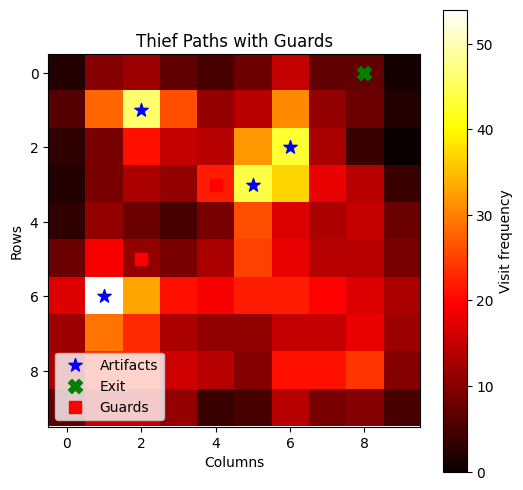

In [ ]:
rows, cols = 10, 10
artifact_positions = [(1, 2), (3, 5), (6, 1), (2, 6)]


exit_pos = (0, 8)
guards = {(3, 4), (5, 2)}  # some fixed guards

results = multiple_thieves_with_guards(50, artifact_positions, exit_pos, rows, cols, guards)
analyze_with_guards(results, rows, cols, exit_pos, artifact_positions, guards)


In [ ]:
def optimize_guards(num_trials, num_thieves, artifact_positions, exit_pos, rows, cols, num_guards=3, max_steps=50):
    best_setup = None
    best_catch_rate = -1
    all_results = []

    for trial in range(num_trials):
        # randomly place guards
        guards = set()
        while len(guards) < num_guards:
            g = (random.randint(0, rows-1), random.randint(0, cols-1))
            if g not in artifact_positions and g != exit_pos:
                guards.add(g)

        # simulate thieves for this guard placement
        results = multiple_thieves_with_guards(num_thieves, artifact_positions, exit_pos, rows, cols, guards, max_steps)

        caught = sum(1 for r in results if r["result"] == "caught")
        escaped = sum(1 for r in results if r["result"] == "escaped")
        catch_rate = caught / num_thieves

        all_results.append({
            "guards": guards,
            "caught": caught,
            "escaped": escaped,
            "catch_rate": catch_rate
        })

        if catch_rate > best_catch_rate:
            best_catch_rate = catch_rate
            best_setup = guards

    print(f"🏆 Best Catch Rate: {best_catch_rate*100:.1f}%")
    print(f"🛡️ Best Guard Placement: {best_setup}")
    return best_setup, all_results


In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

def prepare_ml_data(all_results, rows, cols):
    """
    Convert guard placement results into a numeric dataset.
    Each grid cell becomes a binary feature (1 = guard present, 0 = not).
    """
    data = []
    for res in all_results:
        features = np.zeros(rows * cols)
        for (r, c) in res["guards"]:
            features[r * cols + c] = 1  # encode guard position as 1
        features = list(features)
        features.append(res["catch_rate"])
        data.append(features)

    # create column names
    columns = [f"cell_{i}" for i in range(rows * cols)] + ["catch_rate"]
    return pd.DataFrame(data, columns=columns)


def train_guard_model(all_results, rows, cols):
    """
    Train a regression model to predict catch_rate from guard positions.
    """
    df = prepare_ml_data(all_results, rows, cols)
    X = df.drop("catch_rate", axis=1)
    y = df["catch_rate"]

    model = LinearRegression()
    model.fit(X, y)
    print("✅ ML model trained!")
    print("📈 Model R² score:", model.score(X, y))

    return model


def predict_guard_value(model, rows, cols):
    """
    Predict which grid cells are most 'valuable' for placing guards.
    """
    cell_values = []
    for i in range(rows * cols):
        vec = np.zeros(rows * cols)
        vec[i] = 1
        pred = model.predict([vec])[0]
        cell_values.append(pred)

    value_matrix = np.array(cell_values).reshape(rows, cols)
    plt.figure(figsize=(6,6))
    plt.imshow(value_matrix, cmap="coolwarm", interpolation="nearest")
    plt.colorbar(label="Predicted Guard Effectiveness")
    plt.title("ML-Predicted Guard Value Map")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.show()

    return value_matrix


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def adaptive_guard_simulation(artifact_positions, exit_pos, rows, cols, num_guards=3, num_thieves=10, rounds=10):
    """
    Guards adapt their positions after every round based on thief movement results.
    """
    # Step 1: initialize random guards
    guards = [(random.randint(0, rows-1), random.randint(0, cols-1)) for _ in range(num_guards)]

    # track for plotting
    guard_positions_over_time = [guards.copy()]

    for r in range(rounds):
        # Step 2: simulate thieves for this round
        thief_paths = multiple_thieves_with_guards(num_thieves, artifact_positions, exit_pos, rows, cols, guards)

        thief_ends = [p["path"][-1] for p in thief_paths]


        # Step 3: compute which thieves escaped
        escaped = [pos for pos in thief_ends if pos == exit_pos]
        caught = num_thieves - len(escaped)
        print(f"Round {r+1}: Caught = {caught}, Escaped = {len(escaped)}")

        # Step 4: find "escape hot zone" — where thieves passed through most
        heatmap = np.zeros((rows, cols))
        for result in thief_paths:               # result = one thief’s data dictionary
            path = result["path"]                # get list of positions
            for (x, y) in path:                  # unpack coordinates
                heatmap[x, y] += 1



        # Step 5: move guards slightly toward hot zones
        new_guards = []
        for g in guards:
            # find nearby area with high thief activity
            neigh = neighbors(g, rows, cols)
            best = max(neigh, key=lambda n: heatmap[n[0], n[1]], default=g)
            new_guards.append(best)

        guards = new_guards
        guard_positions_over_time.append(guards.copy())

    # Step 6: visualize guard movements over time
    plt.figure(figsize=(6,6))
    for i, gset in enumerate(guard_positions_over_time):
        xs, ys = zip(*gset)
        plt.scatter(ys, xs, label=f"Round {i+1}", s=100)
    plt.gca().invert_yaxis()
    plt.title("Adaptive Guard Movement Over Rounds")
    plt.legend()
    plt.show()

    return guards


Round 1: Caught = 9, Escaped = 1
Round 2: Caught = 10, Escaped = 0
Round 3: Caught = 10, Escaped = 0
Round 4: Caught = 10, Escaped = 0
Round 5: Caught = 9, Escaped = 1
Round 6: Caught = 10, Escaped = 0
Round 7: Caught = 10, Escaped = 0
Round 8: Caught = 10, Escaped = 0
Round 9: Caught = 10, Escaped = 0
Round 10: Caught = 10, Escaped = 0


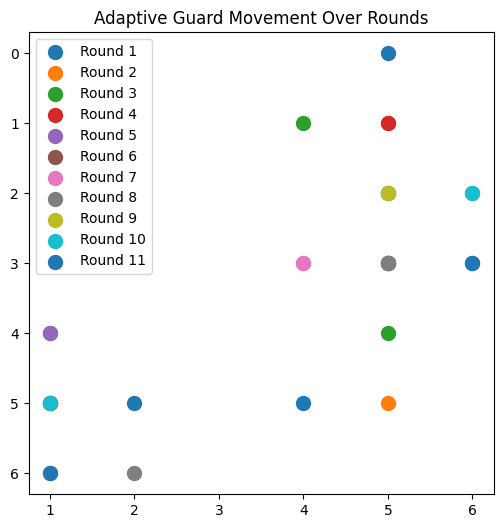

[(3, 6), (6, 1), (3, 6)]

In [ ]:
adaptive_guard_simulation(
    artifact_positions=artifacts,
    exit_pos=exit_pos,
    rows=rows,
    cols=cols,
    num_guards=3,
    num_thieves=10,
    rounds=10
)
